In [11]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr

In [12]:
import DarkVerse as dv


In [13]:
home_dir = os.path.expanduser('~')
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 
res = os.path.join(home_dir, 'Master_Thesis', 'Results')



In [4]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



# Catalog
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  
t= Table.read(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  
t3= Table.read(masked_file_path)

# Join in one table

t=join(t,t3,keys='id') 
t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')


# Load Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 
t2 = Table.read(fits_random)
randoms = t2  # Random catalog

# Define Correlation Function Configuration
config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}



z_min=0.6
z_max=0.7
SM_min=10.5
SM_max=11

# Select Subsample
subsample = dv.Subsample(catalog=t, randoms=randoms, z_min=z_min, z_max=z_max, SM_min=SM_min, SM_max=SM_max, config=config)

# Get Results
results = subsample.get_results()

print(f"Power Law Parameters (A, gamma): {results['power_law_params']}")
print()
#print(f"w_theta: {results['w_theta']}")
#print(f"DD counts: {results['dd_counts']}")
#print(f"DR counts: {results['dr_counts']}")
#print(f"RR counts: {results['rr_counts']}")


The following patch numbers have no objects: {40}
This may be a problem depending on your use case.
The following patch numbers have no objects: {30}
This may be a problem depending on your use case.
The following patch numbers have no objects: {38}
This may be a problem depending on your use case.
The following patch numbers have no objects: {43}
This may be a problem depending on your use case.
The following patch numbers have no objects: {39}
This may be a problem depending on your use case.


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)


Power Law Parameters (A, gamma): [7.34351569e-04 1.40158084e+00]



Errors on w_theta: [0.73818446 0.67080024 0.6098664  0.5545965  0.50449917 0.4589924
 0.41768228 0.38004545 0.34587072 0.3148239  0.28669943 0.26116775
 0.23801052 0.21701342 0.19797867 0.18071091 0.16506073 0.15088267
 0.13801592 0.12623625 0.11535048 0.10525439 0.0960246  0.08755188
 0.07982535 0.07278896 0.06640706 0.06058886 0.05531174 0.0505085
 0.04616694 0.0421653  0.0385267  0.03521238 0.03224704 0.02953658
 0.02707581 0.02481124 0.02273447 0.02064641 0.01856067 0.01690089
 0.01561406 0.01442042 0.0133624  0.01243469 0.0115061  0.01054159
 0.0097582  0.00914587 0.00857367 0.00791966 0.00736048 0.00687587
 0.00637404 0.00597589 0.00562644 0.00539934 0.00529443 0.00533784
 0.00561192 0.00608284 0.00724778 0.01003855]


/tmp/ipykernel_2386391/2901281716.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


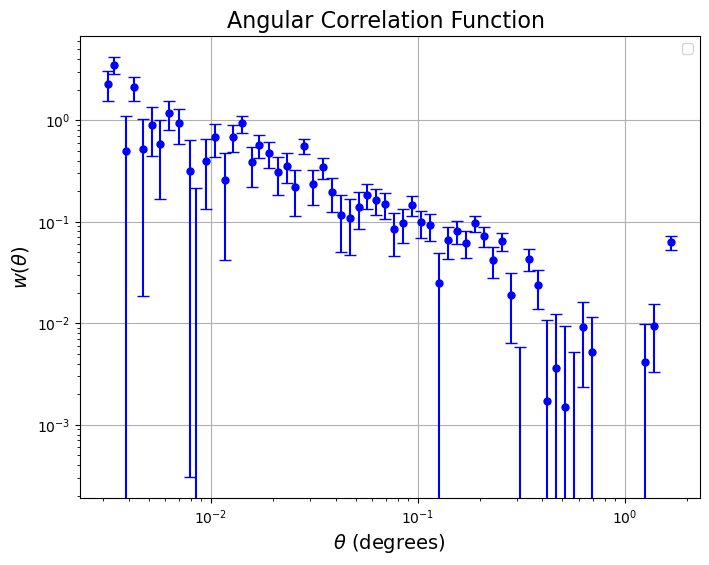

In [5]:

theta_values = results['theta']
w_theta_values = results['w_theta']
var_w_theta_values = results['var_w_theta']

# Compute errors (standard deviation)
w_theta_errors = np.sqrt(var_w_theta_values)

print("Errors on w_theta:", w_theta_errors)


plt.figure(figsize=(8, 6))
plt.errorbar(theta_values, w_theta_values, yerr= w_theta_errors, fmt='o', color='blue', capsize=4, markersize=5)

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function ', fontsize=16)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()


### ^these errors are way too big wtf is going on??

In [6]:
gg = subsample.compute_gg()  



In [7]:


# Compute correlation functions
theta, xi_g, xi_m = subsample.compute_gg()

results = subsample.get_results()

#print("Galaxy-Galaxy Angular Correlation:", results['xi_g'])
#print("Matter-Matter Angular Correlation:", results['xi_m'])


Errors on w_theta: [0.73818446 0.67080024 0.6098664  0.5545965  0.50449917 0.4589924
 0.41768228 0.38004545 0.34587072 0.3148239  0.28669943 0.26116775
 0.23801052 0.21701342 0.19797867 0.18071091 0.16506073 0.15088267
 0.13801592 0.12623625 0.11535048 0.10525439 0.0960246  0.08755188
 0.07982535 0.07278896 0.06640706 0.06058886 0.05531174 0.0505085
 0.04616694 0.0421653  0.0385267  0.03521238 0.03224704 0.02953658
 0.02707581 0.02481124 0.02273447 0.02064641 0.01856067 0.01690089
 0.01561406 0.01442042 0.0133624  0.01243469 0.0115061  0.01054159
 0.0097582  0.00914587 0.00857367 0.00791966 0.00736048 0.00687587
 0.00637404 0.00597589 0.00562644 0.00539934 0.00529443 0.00533784
 0.00561192 0.00608284 0.00724778 0.01003855]


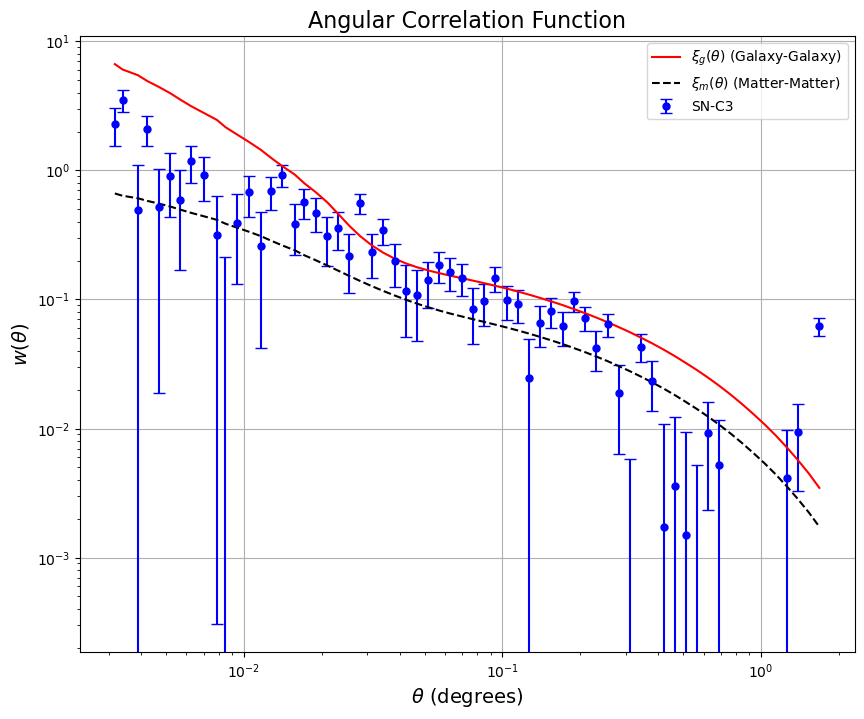

In [8]:

theta_values = results['theta']
w_theta_values = results['w_theta']
var_w_theta_values = results['var_w_theta']
xi_g_values = results['xi_g']
xi_m_values = results['xi_m']

# Compute errors (standard deviation)
w_theta_errors = np.sqrt(var_w_theta_values)

print("Errors on w_theta:", w_theta_errors)

plt.figure(figsize=(10, 8))
plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors, fmt='o', 
             color='blue', capsize=4, markersize=5, label='SN-C3')

# Plot galaxy and matter correlation functions
plt.plot(theta_values, xi_g_values, label=r'$\xi_{g}(\theta)$ (Galaxy-Galaxy)', linestyle='-', color='red')
plt.plot(theta_values, xi_m_values, label=r'$\xi_{m}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$ w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


In [9]:


bias_estimator = dv.BiasEstimator(
    xi_g=results['xi_g'],
    xi_m=results['xi_m'],
    w_theta_list=[results['w_theta']], 
    w_theta_error_list=[results['var_w_theta']], 
    sum_rr_list=[results['rr_counts']], 
    mask = (theta_values >= 0.1) & (theta_values <= 0.4)
)

bias_values, bias_errors = bias_estimator.estimate_bias()
print("Bias values:", bias_values)
print("Bias errors:", bias_errors)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 64

In [ ]:
xi_m_values = np.array(results['xi_m'])  # Matter-matter correlation function
IC_values = np.array(bias_estimator.IC_list)  # Integral Constraint correction

# Compute the model: xi_m * b^2 - IC
model_values = xi_m_values * bias_values[0]**2 - IC_values[0]  # single subsample

In [ ]:
plt.figure(figsize=(10, 8))
plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors, fmt='o', 
             color='blue', capsize=4, markersize=5, label='SN-C3')

# Plot galaxy and matter correlation functions
plt.plot(theta_values, xi_g_values, label=r'$\xi_{g}(\theta)$ (Galaxy-Galaxy)', linestyle='-', color='red')
plt.plot(theta_values, xi_m_values, label=r'$\xi_{m}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')

plt.plot(theta_values, model_values, label=r'Model', color='g')
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$ w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function', fontsize=16)

# Add legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [ ]:

print("\n--- Subsample Information ---")
print(f"Redshift range: {subsample.z_min} ≤ z ≤ {subsample.z_max}")
print(f"Stellar Mass range: {subsample.SM_min} ≤ SM ≤ {subsample.SM_max}")
print(f"Number of galaxies in subsample: {len(subsample.filtered_catalog)}")


In [ ]:


print("\n--- Bootstrap Error Estimations ---")
print("Variance from bootstrap:", results['var_w_theta_bootstrap'])
print("Covariance Matrix:\n", results['covariance_w_theta_bootstrap'])


In [ ]:
w_theta_errors_bootstrap= np.sqrt(results['var_w_theta_bootstrap'])

In [ ]:
"""bootstrap_w_theta = []

for i in range(100):  
    sample_indices = np.random.choice(len(subsample.filtered_catalog), size=len(subsample.filtered_catalog), replace=True)
    bs_galaxies = subsample.filtered_catalog[sample_indices]
    
    bs_corr = dv.CorrelationFunction(bs_galaxies, randoms, config)
    bs_corr.process()
    w_theta_bs, _, _ ,_, _, _ = bs_corr.calculate_w_theta()
    
    bootstrap_w_theta.append(w_theta_bs)

variance_bootstrap = np.var(bootstrap_w_theta, axis=0)
covariance = np.cov(bootstrap_w_theta)

std_dev= np.std(bootstrap_w_theta, axis=0) #woks better with axis=0 than axis=1 (errors are very big in the latter case)
print(std_dev)
std_dev.shape

print(np.sqrt(variance_bootstrap))

"""

In [ ]:

mask = (theta_values >= 0.1) & (theta_values <= 0.4)

xi_g = np.array(results['xi_g'])
xi_m = np.array(results['xi_m'])
w_theta = np.array(results['w_theta']) 
w_theta_errors_bootstrap = np.array(w_theta_errors_bootstrap) 


bias_estimator = dv.BiasEstimator(
    xi_g=xi_g,
    xi_m=xi_m,
    w_theta_list=[w_theta], 
    w_theta_error_list=[w_theta_errors],  # Bootstrap errors 
    sum_rr_list=[results['rr_counts']], 
    mask=mask  
)

bias_values, bias_errors = bias_estimator.estimate_bias()
print("Bias values:", bias_values)
print("Bias errors:", bias_errors)


In [ ]:
plt.figure(figsize=(10, 8))
plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors, fmt='o', 
             color='orange', capsize=4, markersize=5, label='treecorr ')  # Careful I changed in config 'var_method' to'shot', so this is Poisson noise

plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors_bootstrap, fmt='o', color='blue', capsize=4, markersize=5, label='bootstrap')


plt.plot(theta_values, model_values, label=r'Model', color='g')
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$ w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function', fontsize=16)

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
IC_values = np.array(bias_estimator.IC_list)  # Integral Constraint correction
model_values = xi_m_values * bias_values[0]**2 - IC_values[0]  # single subsample

N = len(subsample.filtered_catalog)  # Number of galaxies in the subsample
print(f"Number of galaxies in subsample: {results['N']}")

IC = bias_estimator.integral_constraint(xi_m, results['rr_counts'])

print("\nSubsample Information:")
print(f"  - Redshift range: {subsample.z_min} ≤ z < {subsample.z_max}")
print(f"  - Stellar mass range: {subsample.SM_min} ≤ SM < {subsample.SM_max}")
print(f"  - Number of galaxies: {N}")
print(f"  - Bias: {bias_values[0]:.3f} ± {bias_errors[0]:.3f}")


# Now I am trying all 4 fields

In [10]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
     },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
        
}}


areas = {
    "SN-X3": 1.297,
    "SN-C3": 1.340,
    "SN-E2": 1.103,
    "COSMOS": 0.893
}

z_min, z_max = 0.6, 0.7
SM_min, SM_max = 10.5, 11

config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}

bias_results = {}

for field, paths in fields.items():
    print(f"🔹 Processing field: {field}")

    # Load galaxy catalog & masked catalog
    catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
    masked = Table.read(os.path.join(thesis_path, paths["masked"]))

    # Join tables on ID
    catalog = join(catalog, masked, keys='id')
    catalog.rename_column('ra_1', 'ra')
    catalog.rename_column('dec_1', 'dec')

    # Load randoms
    randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))

    # Select subsample
    subsample = dv.Subsample(catalog=catalog, randoms=randoms, 
                             z_min=z_min, z_max=z_max, 
                             SM_min=SM_min, SM_max=SM_max, 
                             config=config)

    results = subsample.get_results()
    theta_values = results['theta']
    theta_mask = (theta_values >= 0.1) & (theta_values <= 0.4)


    bias_estimator = dv.BiasEstimator(
        xi_g=results['xi_g'],
        xi_m=results['xi_m'],
        w_theta_list=[results['w_theta']], 
        w_theta_error_list=[np.sqrt(results['var_w_theta_bootstrap'])], 
        sum_rr_list=[results['rr_counts']], 
        mask=theta_mask
    )

    bias_values, bias_errors = bias_estimator.estimate_bias()
    
    bias_results[field] = {
        "bias_values": bias_values,
        "bias_errors": bias_errors
    }

    print(f"Bias for {field}: {bias_values}")
    print(f" Bias errors for {field}: {bias_errors}")
    print()
    
    N = results['N']
    print(f"Number of galaxies in {field}: {N}")

    # Compute nav
    area = areas[field]  # Select the corresponding area for the field
    nav = np.average(N / area)
    print(f'nav for {field}:', nav)

    # Compute overdensity
    del_b = ((N / area) / nav - 1) / bias_values
    print(f"Overdensity (del_b) for {field}: {del_b}")
    print()




🔹 Processing field: SN-X3
The following patch numbers have no objects: {28}
This may be a problem depending on your use case.
The following patch numbers have no objects: {28}
This may be a problem depending on your use case.
The following patch numbers have no objects: {30}
This may be a problem depending on your use case.


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 64

In [ ]:

print("\n Bias Comparison Across Fields:")
for field, bias_data in bias_results.items():
    print(f"{field}: Bias = {bias_data['bias_values']}, Errors = {bias_data['bias_errors']}")



## Field areas (sq. deg.):

COSMOS: 0.893
SN-C3: 1.340
SN-E2: 1.103
SN-X3: 1.297


density average = N/areas

### ^ bigger errors in X3 and E2 bc more of the area was thrown away so we have less galaxies so the errors on the corrlation functions are bigger aka bigger errors in the bias

In [ ]:
z_ranges = [(0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8)] 
SM_min, SM_max = 10.5, 11  

config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # 'shot' for faster, 'bootstrap' for more accurate but slower results
}

# Dictionary to store bias results for each field and redshift range
bias_results = {}

# Loop over each field
for field, paths in fields.items():
    print(f"🔹 Processing field: {field}")

    # Load galaxy catalog & masked catalog
    catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
    masked = Table.read(os.path.join(thesis_path, paths["masked"]))

    # Join the catalogs
    catalog = join(catalog, masked, keys='id')
    catalog.rename_column('ra_1', 'ra')
    catalog.rename_column('dec_1', 'dec')

    # Load randoms catalog
    randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))

    # Loop over each redshift range and create subsample
    for z_min, z_max in z_ranges:
        print(f"  Processing z range: {z_min} to {z_max}")

        # Create subsample for this redshift range
        subsample = dv.Subsample(catalog=catalog, randoms=randoms, 
                                 z_min=z_min, z_max=z_max, 
                                 SM_min=SM_min, SM_max=SM_max, 
                                 config=config)

        # Get the results for the subsample
        results = subsample.get_results()

        # Define theta values and apply mask for the bias estimator
        theta_values = results['theta']
        theta_mask = (theta_values >= 0.1) & (theta_values <= 0.4)

        # Compute bias for this subsample
        bias_estimator = dv.BiasEstimator(
            xi_g=results['xi_g'],
            xi_m=results['xi_m'],
            w_theta_list=[results['w_theta']], 
            w_theta_error_list=[np.sqrt(results['var_w_theta_bootstrap'])], 
            sum_rr_list=[results['rr_counts']], 
            mask=theta_mask
        )

        bias_values, bias_errors = bias_estimator.estimate_bias()

        # Store the results for each field and redshift range
        bias_results_key = f"{field}_z{z_min}-{z_max}"
        bias_results[bias_results_key] = {
            "bias_values": bias_values,
            "bias_errors": bias_errors
        }

        print(f"  Bias for z range {z_min}-{z_max}: {bias_values}")
        print(f"  Bias errors for z range {z_min}-{z_max}: {bias_errors}")
        print()




In [ ]:
print("\n📊 Final Bias Results:\n")

fields_in_results = set(key.split('_z')[0] for key in bias_results.keys())

for field in sorted(fields_in_results):
    print(f"🔸 Field: {field}")
    
    # Find all redshift entries for this field
    field_entries = {key: val for key, val in bias_results.items() if key.startswith(field)}

    for key, bias_data in sorted(field_entries.items()):
        # Extract redshift range from the key
        z_range = key.split('_z')[1]  # e.g., '0.3-0.4'

        b = bias_data['bias_values'][0]
        be = bias_data['bias_errors'][0]

        print(f"   z range {z_range}: Bias = {b:.2f}, Error = {be:.2f}")
    
    print()  


In [ ]:

field_colors = {
    "SN-X3": "blue",
    "SN-C3": "red",
    "SN-E2": "green",
    "COSMOS": "purple"
}

plt.figure(figsize=(10, 6))
field_labels = {}

# Loop over the bias results to plot each field's biases against redshift
for field_z, bias_data in bias_results.items():
    bias_values = bias_data['bias_values']
    bias_errors = bias_data['bias_errors']
    
    # Extract the redshift range from the field_z key
    field, z_range = field_z.split('_z')
    z_min, z_max = map(float, z_range.split('-'))
    
    # Average redshift for the range 
    z_avg = (z_min + z_max) / 2

    # Use the predefined color for the field
    color = field_colors.get(field, "black")  # Default to black if field not in dictionary

    # Only add the field to the legend once
    if field not in field_labels:
        plt.errorbar(z_avg, bias_values, yerr=bias_errors, fmt='o', color=color, label=field, capsize=5)
        field_labels[field] = True  # Mark as added
    else:
        plt.errorbar(z_avg, bias_values, yerr=bias_errors, fmt='o', color=color, capsize=5)

plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel('Bias', fontsize=14)
plt.title('Bias for the 4 fields (high SM)', fontsize=16)
plt.legend(title='Field', fontsize=12)
plt.savefig(os.path.join(res, 'biases-4fields-highSM'))

plt.grid(True)
plt.show()



In [ ]:

# Config and redshift bin
z_min, z_max = 0.7, 0.8   # Highest redshift bin
SM_min, SM_max = 10.5, 11
config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'  # fast, can swap to 'bootstrap' for precision
}

# Load SN-E2 data
field = 'SN-E2'
paths = fields[field]

catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
masked = Table.read(os.path.join(thesis_path, paths["masked"]))
catalog = join(catalog, masked, keys='id')
catalog.rename_column('ra_1', 'ra')
catalog.rename_column('dec_1', 'dec')
randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))

# Subsample and results
subsample = dv.Subsample(catalog=catalog, randoms=randoms, 
                         z_min=z_min, z_max=z_max, 
                         SM_min=SM_min, SM_max=SM_max, 
                         config=config)

results = subsample.get_results()

# Extract values
theta_values = np.array(results['theta'])
w_theta_values = np.array(results['w_theta'])
w_theta_errors = np.sqrt(results['var_w_theta_bootstrap']) 

xi_g_values = np.array(results['xi_g'])
xi_m_values = np.array(results['xi_m'])

# Mask for bias estimator
theta_mask = (theta_values >= 0.1) & (theta_values <= 0.4)

# Bias Estimation
bias_estimator = dv.BiasEstimator(
    xi_g=xi_g_values,
    xi_m=xi_m_values,
    w_theta_list=[w_theta_values], 
    w_theta_error_list=[w_theta_errors], 
    sum_rr_list=[results['rr_counts']], 
    mask=theta_mask
)

bias_values, bias_errors = bias_estimator.estimate_bias()
print(f"Bias SN-E2 z=0.7-0.8: {bias_values[0]:.3f} ± {bias_errors[0]:.3f}")

# Model Fit: xi_m * b² - IC
IC_values = np.array(bias_estimator.IC_list)
model_values = xi_m_values * bias_values[0]**2 - IC_values[0]

# Plotting
plt.figure(figsize=(10, 8))
plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors, fmt='o', 
             color='blue', capsize=4, markersize=5, label=r'$w(\theta)$ SN-E2')

plt.plot(theta_values, xi_g_values, label=r'$\xi_{g}(\theta)$ (Galaxy)', linestyle='-', color='red')
plt.plot(theta_values, xi_m_values, label=r'$\xi_{m}(\theta)$ (Matter)', linestyle='--', color='black')
plt.plot(theta_values, model_values, label='Model', color='green')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title(f'SN-E2 Angular Correlation @ z={z_min}-{z_max}', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:

# Define home directory and thesis path
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
     },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}

# Configurations
z_min, z_max = 0.6, 0.7
SM_min, SM_max = 10.5, 11

config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'
}

# Define colors and markers for each field
colors = {"SN-X3": "blue", "SN-C3": "red", "SN-E2": "green", "COSMOS": "purple"}
markers = {"SN-X3": "o", "SN-C3": "s", "SN-E2": "^", "COSMOS": "d"}

plt.figure(figsize=(10, 8))

for field, paths in fields.items():
    print(f"🔹 Processing field: {field}")

    # Load data
    catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
    masked = Table.read(os.path.join(thesis_path, paths["masked"]))
    catalog = join(catalog, masked, keys='id')
    catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])

    randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))

    # Compute subsample
    subsample = dv.Subsample(catalog=catalog, randoms=randoms, 
                             z_min=z_min, z_max=z_max, 
                             SM_min=SM_min, SM_max=SM_max, 
                             config=config)

    results = subsample.get_results()

    theta_values = np.array(results['theta'])
    w_theta_values = np.array(results['w_theta'])
    w_theta_errors = np.sqrt(results['var_w_theta_bootstrap']) 

    xi_g_values = np.array(results['xi_g'])
    xi_m_values = np.array(results['xi_m'])

    theta_mask = (theta_values >= 0.1) & (theta_values <= 0.4)

    bias_estimator = dv.BiasEstimator(
        xi_g=xi_g_values,
        xi_m=xi_m_values,
        w_theta_list=[w_theta_values], 
        w_theta_error_list=[w_theta_errors], 
        sum_rr_list=[results['rr_counts']], 
        mask=theta_mask
    )

    bias_values, bias_errors = bias_estimator.estimate_bias()
    IC_values = np.array(bias_estimator.IC_list)
    model_values = xi_m_values * bias_values[0]**2 - IC_values[0]

    # Plot w_theta with error bars
    plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors, fmt=markers[field], 
                 color=colors[field], capsize=4, markersize=5, label=rf'$w(\theta)$ {field}')

    # Plot xi_g, xi_m, and model as lines
    #plt.plot(theta_values, xi_g_values, linestyle='-', color=colors[field], alpha=0.6, label=rf'$\xi_g(\theta)$ {field}')
    #plt.plot(theta_values, xi_m_values, linestyle='--', color=colors[field], alpha=0.6, label=rf'$\xi_m(\theta)$ {field}')
    plt.plot(theta_values, model_values, linestyle='-.', color=colors[field], alpha=0.8, label=rf'Model {field}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title(f'Angular Correlation for All Fields @ z={z_min}-{z_max}', fontsize=16)
plt.legend(fontsize=10, loc='best')
plt.tight_layout()
plt.show()


In [ ]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
     },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}

# Configurations
z_min, z_max = 0.6, 0.7
SM_min, SM_max = 10.5, 11

config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'
}

colors = {"SN-X3": "blue", "SN-C3": "red", "SN-E2": "green", "COSMOS": "purple"}
markers = {"SN-X3": "o", "SN-C3": "s", "SN-E2": "^", "COSMOS": "d"}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid for 4 fields
axes = axes.flatten()  # Flatten to make indexing easier

for i, (field, paths) in enumerate(fields.items()):
    print(f"🔹 Processing field: {field}")

    # Load data
    catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
    masked = Table.read(os.path.join(thesis_path, paths["masked"]))
    catalog = join(catalog, masked, keys='id')
    catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])

    randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))

    # Compute subsample
    subsample = dv.Subsample(catalog=catalog, randoms=randoms, 
                             z_min=z_min, z_max=z_max, 
                             SM_min=SM_min, SM_max=SM_max, 
                             config=config)

    results = subsample.get_results()

    theta_values = np.array(results['theta'])
    w_theta_values = np.array(results['w_theta'])
    w_theta_errors = np.sqrt(results['var_w_theta_bootstrap']) 

    xi_g_values = np.array(results['xi_g'])
    xi_m_values = np.array(results['xi_m'])

    theta_mask = (theta_values >= 0.1) & (theta_values <= 0.4)

    bias_estimator = dv.BiasEstimator(
        xi_g=xi_g_values,
        xi_m=xi_m_values,
        w_theta_list=[w_theta_values], 
        w_theta_error_list=[w_theta_errors], 
        sum_rr_list=[results['rr_counts']], 
        mask=theta_mask
    )

    bias_values, bias_errors = bias_estimator.estimate_bias()
    IC_values = np.array(bias_estimator.IC_list)
    model_values = xi_m_values * bias_values[0]**2 - IC_values[0]

    ax = axes[i]  
    ax.errorbar(theta_values, w_theta_values, yerr=w_theta_errors, fmt=markers[field], 
                color=colors[field], capsize=4, markersize=5, label=rf'$w(\theta)$ {field}')

    ax.plot(theta_values, model_values, linestyle='-.', color=colors[field], alpha=0.8, label=rf'Model {field}')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ (degrees)', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'Field: {field}', fontsize=14)
    ax.legend(fontsize=10, loc='best')

plt.tight_layout()
plt.show()


# Where i am working rn in this code

In [15]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}

# Configurations
z_min, z_max = 0.6, 0.7
SM_min, SM_max = 10.5, 11

config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'
}

# Store combined data
all_theta = []
all_w_theta = []
all_w_theta_errors = []
all_sum_rr_list = []
all_xi_g = []
all_xi_m = []

all_IC = []


colors = {"SN-X3": "blue", "SN-C3": "red", "SN-E2": "green", "COSMOS": "purple"}


for i, (field, paths) in enumerate(fields.items()):
    print(f"🔹 Processing field: {field}")

    # Load data
    catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
    masked = Table.read(os.path.join(thesis_path, paths["masked"]))
    catalog = join(catalog, masked, keys='id')
    catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])

    randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))

    # Compute subsample
    subsample = dv.Subsample(catalog=catalog, randoms=randoms, 
                             z_min=z_min, z_max=z_max, 
                             SM_min=SM_min, SM_max=SM_max, 
                             config=config)

    results = subsample.get_results()

    # Extract values from results
    theta_values = np.array(results['theta'])
    w_theta_values = np.array(results['w_theta'])
    w_theta_errors = np.sqrt(results['var_w_theta_bootstrap']) 
    xi_g_values = np.array(results['xi_g'])
    xi_m_values = np.array(results['xi_m'])
    sum_rr_list =  np.array(results['rr_counts'])

    theta_mask = (theta_values >= 0.1) & (theta_values <= 0.4)


    # Combine the results into the global arrays
    all_theta = np.hstack([all_theta, theta_values])
    all_w_theta = np.hstack([all_w_theta, w_theta_values])
    all_w_theta_errors = np.hstack([all_w_theta_errors, w_theta_errors])
    all_xi_m = np.hstack([all_xi_m, xi_m_values])
    all_xi_g = np.hstack([all_xi_g, xi_g_values])
    all_sum_rr_list = np.hstack([all_sum_rr_list,sum_rr_list])

    bias_esti = dv.BiasEstimator(
        xi_g=xi_g_values,
        xi_m=xi_m_values,
        w_theta_list=w_theta_values, 
        w_theta_error_list= w_theta_errors, 
        sum_rr_list= results['rr_counts'], 
        mask=theta_mask
    )

    bias_values, bias_errors = bias_esti.estimate_bias()
    print(bias_values)
    IC_values = bias_esti.IC_list

    all_IC.append(IC_values)




🔹 Processing field: SN-X3
The following patch numbers have no objects: {27}
This may be a problem depending on your use case.
The following patch numbers have no objects: {29}
This may be a problem depending on your use case.
[ 1.08438787  1.19074705  0.84597527  0.47607458  0.75950572 -0.39097907
  0.42981286  0.36881971  0.16338621 -0.79444381  0.64629679  0.71316351
 -1.59459899 -0.27083595]
[40.71653857038938]
🔹 Processing field: SN-C3
The following patch numbers have no objects: {42}
This may be a problem depending on your use case.
The following patch numbers have no objects: {43}
This may be a problem depending on your use case.
The following patch numbers have no objects: {40}
This may be a problem depending on your use case.
The following patch numbers have no objects: {40}
This may be a problem depending on your use case.
[ 1.62066125  1.60402576  0.45381655  1.28351111  1.68451311  1.37708624
  2.29407173  1.85443721  1.17186338  1.93388258  0.6167549  -0.20341586
  1.707980

In [14]:
class BiasEstimator:
    
    def __init__(self, xi_g, xi_m, w_theta_list, w_theta_error_list, sum_rr_list, mask):
        """
        Initializes the BiasEstimator class.

        Parameters:
        - xi_g: np.array, galaxy-galaxy angular correlation function
        - xi_m: np.array, matter-matter angular correlation function
        - w_theta_list: list, observed angular correlation functions
        - w_theta_error_list: list, corresponding errors
        - sum_rr_list: list, RR pair counts
        - mask: np.array, boolean mask for selecting the 2-halo term
        """
        self.xi_g = xi_g  # Galaxy-galaxy angular correlation function      
        self.xi_m = xi_m  # Matter-matter angular correlation function
        self.w_theta_list = w_theta_list
        self.w_theta_error_list = w_theta_error_list
        self.sum_rr_list = sum_rr_list
        self.mask = mask
        self.IC_list = self.calculate_IC_values(self.xi_g)  # Compute Integral Constraint (IC)

    def integral_constraint(self, wg_no_ic, rr):
        """
        Computes the integral constraint correction.

        Parameters:
        - wg_no_ic: np.array, galaxy correlation without IC correction
        - rr: np.array, RR pair counts

        Returns:
        - IC value
        """
        return np.sum(wg_no_ic * rr) / np.sum(rr)
    
    def calculate_IC_values(self, xi):
        """
        Computes the integral constraint correction for each subsample.

        Returns:
        - List of IC values for each subsample
        """
        #return [self.integral_constraint(xi, rr) for rr in self.sum_rr_list]
        return self.integral_constraint(xi, self.sum_rr_list)
    
    def model(self, wdm, b, IC_value=None):
        """
        Model function for bias estimation.

        Parameters:
        - wdm: np.array, matter-matter correlation function
        - b: float, bias parameter
        - IC_value: float, Integral Constraint (IC)

        Returns:
        - Modeled galaxy correlation function
        """
        wg_no_ic = wdm * b**2  # Initial model without IC correction
        
        if IC_value is None:
            IC_value = self.calculate_IC_values(wg_no_ic)
        
        print('IC_value:', IC_value)        
        print('b:',b)
        print()

        
        wg_model = wg_no_ic - IC_value  # Apply correction
        
        return wg_model[self.mask]  # Get only the selected range
    
    def estimate_bias(self):
        """
        Estimates the bias (b) by fitting the matter correlation function to the observed galaxy correlation.

        Returns:
        - b: List of bias values for each sample
        - be: List of bias errors
        """
        b = []  # Bias values
        be = []  # Bias errors


        IC_value = self.IC_list  # Integral Constraint for this sample
        
        matter_corr = np.array(self.xi_m)
        galaxy_corr = np.array(self.w_theta_list)
        errors = np.array(self.w_theta_error_list)
        
        # Ensure arrays have the same length
        min_len = min(len(matter_corr), len(galaxy_corr), len(errors))
        matter_corr = matter_corr[:min_len]
        galaxy_corr = galaxy_corr[:min_len]
        errors = errors[:min_len]

        #print((galaxy_corr/matter_corr)[self.mask])
    
        try:          
            popt, pcov = curve_fit(
                lambda wdm, b: self.model(wdm, b, IC_value),
                matter_corr, 
                galaxy_corr[self.mask],  # Apply mask
                sigma=errors[self.mask], 
                absolute_sigma=True, 
                p0=[1.0],  # Initial guess for bias
                maxfev=10000)  
                
            bias = popt[0]
            bias_error = np.sqrt(np.diag(pcov))[0]
            
            b.append(bias)
            be.append(bias_error)
        
        except RuntimeError:
            b.append(np.nan)
            be.append(np.nan)

        # re-run IC computation with fit bias value
        # assign IC to self.IC_list

               
        if not np.isnan(b[0]): #If the bias estimation failed (due to e.g., curve_fit not converging), it would be NaN. This prevents the rest of the block from running if the fit failed.
            # Recompute wg without IC using the best-fit bias
            wg_no_ic_fit = matter_corr * b[0]**2  # matter_corr is xi_m (theoretical matter-matter correlation).

            # Recompute IC with fitted model
            new_IC = self.integral_constraint(wg_no_ic_fit, self.sum_rr_list)

            # Assign to self.IC_list
            self.IC_list = new_IC

        return b, be



### re-run IC computation with fit bias value
### assign IC to self.IC_list

In [17]:
bias_values, bias_errors = bias_esti.estimate_bias()

IC_values = bias_esti.IC_list

all_IC.append(IC_values)

IC_value: 0.03415900261647065
b: 1.0

IC_value: 0.03415900261647065
b: 1.0000000149011612

IC_value: 0.03415900261647065
b: 1.1818846357889092

IC_value: 0.03415900261647065
b: 1.1818846534003626

IC_value: 0.03415900261647065
b: 1.1678891842659946

IC_value: 0.03415900261647065
b: 1.1678892016688995

IC_value: 0.03415900261647065
b: 1.167805327044943

IC_value: 0.03415900261647065
b: 1.1678053444465986

IC_value: 0.03415900261647065
b: 1.1678053236407335



In [25]:
all_mask = (all_theta >= 0.1) & (all_theta <= 0.4)

all_bias_estimator = dv.BiasEstimator(
    xi_g=all_xi_g,
    xi_m=all_xi_m,
    w_theta_list=all_w_theta,
    w_theta_error_list=all_w_theta_errors,
    sum_rr_list=all_sum_rr_list,
    mask=all_mask
)


all_bias, all_bias_errors = all_bias_estimator.estimate_bias()
print(f"Estimated Bias: {all_bias[0]:.3f} ± {all_bias_errors[0]:.3f}")



[ 1.08438787  1.19074705  0.84597527  0.47607458  0.75950572 -0.39097907
  0.42981286  0.36881971  0.16338621 -0.79444381  0.64629679  0.71316351
 -1.59459899 -0.27083595  1.62066125  1.60402576  0.45381655  1.28351111
  1.68451311  1.37708624  2.29407173  1.85443721  1.17186338  1.93388258
  0.6167549  -0.20341586  1.70798024  1.03451849  2.10587229  1.2001337
 -0.20644449  0.41071949  1.21524717  1.3783172   0.7185184  -0.38654518
  1.5791455  -1.38875742  1.56740962  1.18110867 -0.10250857 -1.44975014
 -0.00514781  1.74176595 -0.47781046  0.84804421  0.42590107  0.5128584
  0.08048865  0.1026986   1.12240192 -0.25974378 -0.25188186  1.34925335
  0.82401828  0.87345846]
Estimated Bias: 80.290 ± 0.001


In [26]:
print(f"all_theta shape: {all_theta.shape}")
print(f"all_xi_g: {all_xi_g.shape}")

print(f"all_sum_rr_list shape: {all_sum_rr_list.shape}")
print(f"all_mask shape: {all_mask.shape}")
print(f"all_w_theta shape: {all_w_theta.shape}")
print(f"all_w_theta_errors shape: {all_w_theta_errors.shape}")
print(f"all_xi_m shape: {all_xi_m.shape}")
print(f"all_IC shape: {len(all_IC)}")

all_theta shape: (256,)
all_xi_g: (256,)
all_sum_rr_list shape: (256,)
all_mask shape: (256,)
all_w_theta shape: (256,)
all_w_theta_errors shape: (256,)
all_xi_m shape: (256,)
all_IC shape: 5


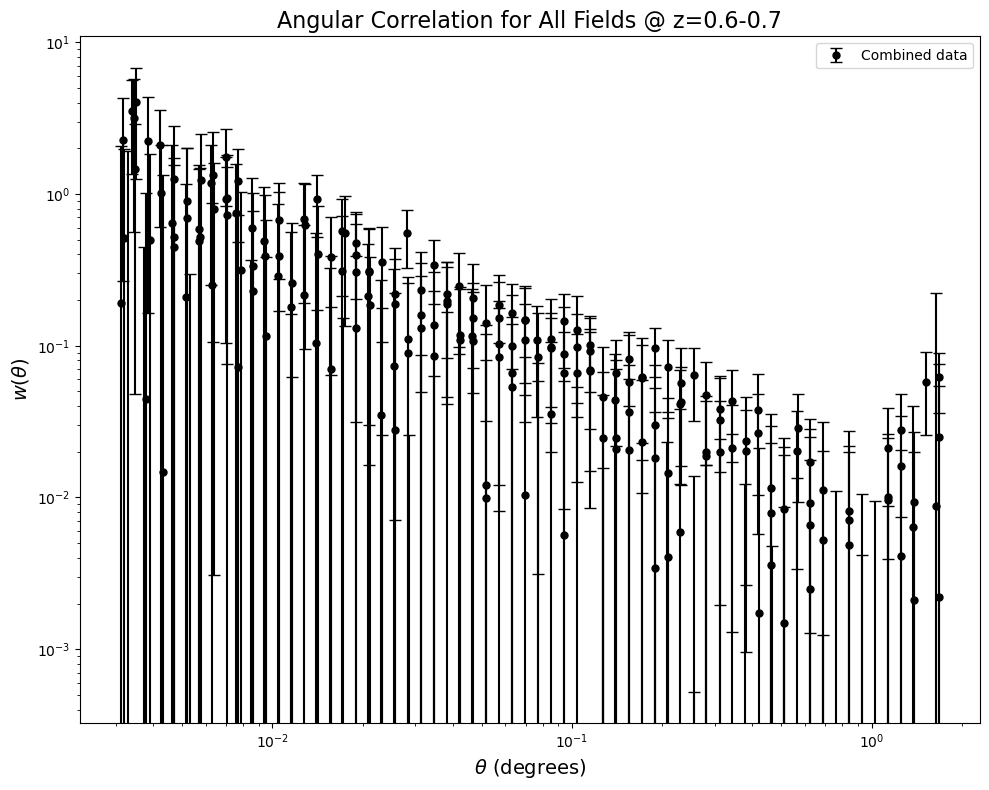

In [27]:

plt.figure(figsize=(10, 8))

plt.errorbar(all_theta, all_w_theta, yerr=all_w_theta_errors, fmt='o', color='black', capsize=4, markersize=5, label='Combined data')
#plt.plot(all_theta, all_xi_m[0] * bias**2 - all_IC[0], 'r-', label='model1')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title(f'Angular Correlation for All Fields @ z={z_min}-{z_max}', fontsize=16)
plt.legend(fontsize=10, loc='best')
plt.tight_layout()
plt.show()


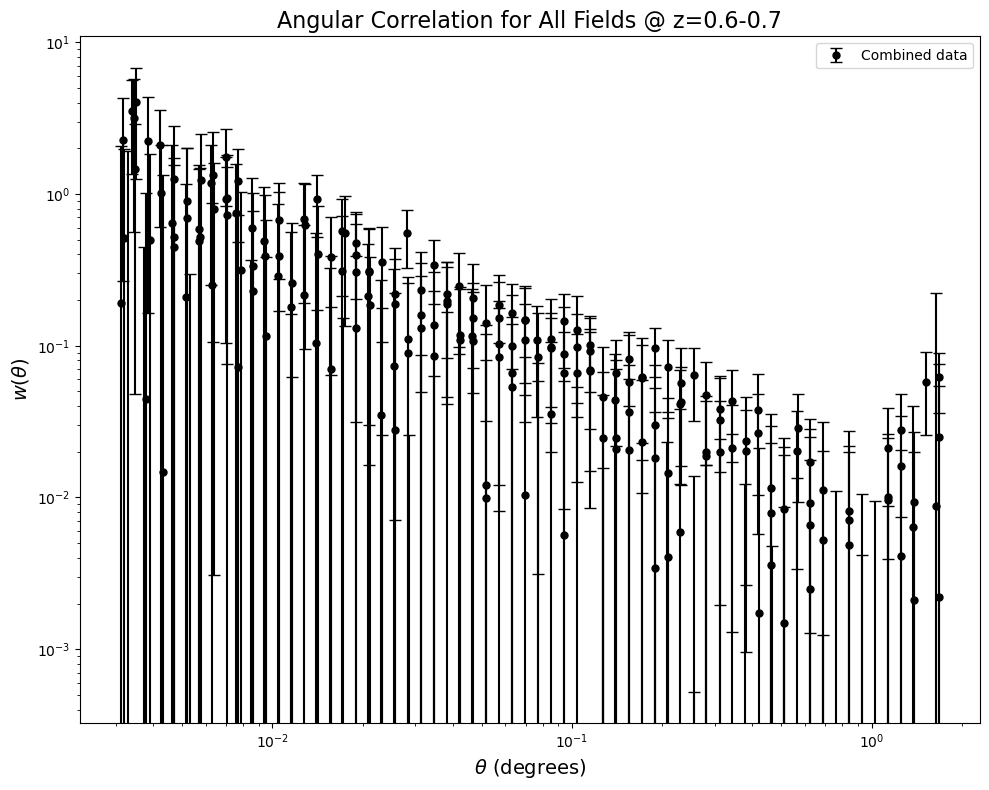

In [30]:

#models = xi_m_values * bias[0]**2 - IC_values[0]

plt.figure(figsize=(10, 8))

#for i in range(4):
    #plt.plot(all_theta[:64], (all_xi_m * bias[0]**2 - all_IC[0]), 'r-', label=f'Model (Bias={bias})')

plt.errorbar(all_theta, all_w_theta, yerr=all_w_theta_errors, fmt='o', 
             color='black', capsize=4, markersize=5, label='Combined data')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title(f'Angular Correlation for All Fields @ z={z_min}-{z_max}', fontsize=16)

plt.legend(fontsize=10, loc='best')  # Legend includes bias value now
plt.tight_layout()
plt.show()


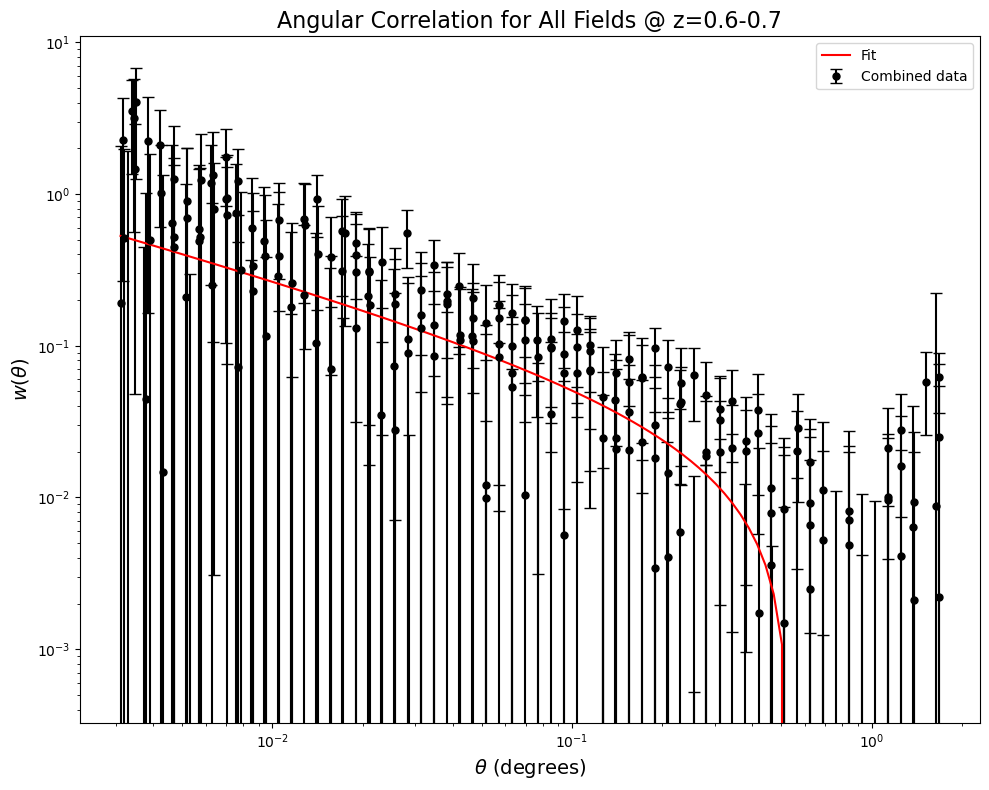

In [31]:
def fit_function(theta, A, alpha, beta):
    return A * (theta**alpha) + beta

popt, pcov = curve_fit(fit_function, all_theta, all_w_theta, sigma=all_w_theta_errors, p0=[1, -1, 0])

plt.figure(figsize=(10, 8))
plt.errorbar(all_theta, all_w_theta, yerr=all_w_theta_errors, fmt='o', color='black', capsize=4, markersize=5, label='Combined data')

theta_fit = np.logspace(np.log10(min(all_theta)), np.log10(max(all_theta)), 100)
w_theta_fit = fit_function(theta_fit, *popt)
plt.plot(theta_fit, w_theta_fit, 'r-', label='Fit')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title(f'Angular Correlation for All Fields @ z={z_min}-{z_max}', fontsize=16)
plt.legend(fontsize=10, loc='best')
plt.tight_layout()
plt.show()
